In [ ]:
import pandas as pd
import numpy as np

from sklearn.svm import LinearSVC
from sklearn.preprocessing import scale

imported packages

In [ ]:
data = pd.read_table('https://code.omicslogic.com/assets/datasets/cell_lines/CellLines_52samples_ExprData_T1.txt',sep='\t',header=(0))

features = data.iloc[1:, 0].values

data=data.drop(['id'], axis = 1) 

dataT = np.transpose(data)

X = dataT.iloc[:, 1:].values
y = dataT.iloc[:, 0].values


classes = np.unique(y)
n_classes = len(classes)
str(classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

len(y_train)

36

we are ready to run a classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = LinearSVC(C=1.0)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
str(predictions)

"['Luminal' 'Luminal' 'Luminal' 'Luminal' 'Basal' 'Basal' 'Claudin-low'\n 'Luminal' 'Claudin-low' 'Basal' 'Luminal' 'Luminal' 'Normal-like'\n 'Normal-like' 'Luminal' 'Basal']"

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm

c_matrix = confusion_matrix(y_test,predictions)
cr = classification_report(y_test,predictions)
model_accuracy = accuracy_score(y_test, predictions)

c_matrix

array([[3, 0, 0, 0],
       [0, 2, 0, 0],
       [0, 0, 8, 0],
       [1, 0, 0, 2]])

Now we can plot the results of the model

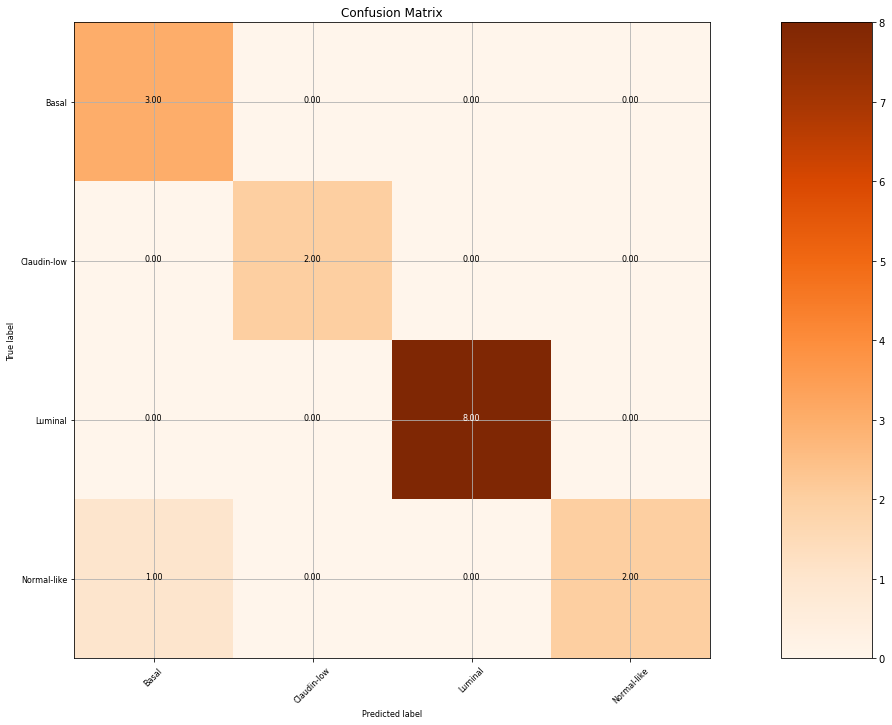

In [ ]:
#Plot confusion matrix
plt.figure(figsize = (20, 10))
plt.imshow(c_matrix, cmap=cm.Oranges)
plt.title('Confusion Matrix', size = 12)
plt.colorbar(aspect=7)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, size = 8)
plt.yticks(tick_marks, classes, size = 8)

fmt = '.2f'
thresh = c_matrix.max() / 2.

for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
    plt.text(j, i, format(c_matrix[i, j], fmt), fontsize = 8,
                horizontalalignment='center',
                color='white' if c_matrix[i, j] > thresh else 'black')

plt.grid(None)
plt.tight_layout()
plt.ylabel('True label', size = 8)
plt.xlabel('Predicted label', size = 8)
plt.show()

Feature selection

In [ ]:
top_features_count = 15
vector_weights = np.median(model.coef_, axis=0)
top_positive_coefficients = np.argsort(vector_weights)[-top_features_count:]
top_negative_coefficients = np.argsort(vector_weights)[:top_features_count]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
top_features, top_features_weights = features[top_coefficients], vector_weights[top_coefficients]
top_table = features[top_coefficients], vector_weights[top_coefficients]
str(top_table)

"(array(['ENSG00000167755', 'ENSG00000172137', 'ENSG00000101443',\n       'ENSG00000148346', 'ENSG00000118849', 'ENSG00000167754',\n       'ENSG00000129451', 'ENSG00000185885', 'ENSG00000196136',\n       'ENSG00000144063', 'ENSG00000102854', 'ENSG00000260549',\n       'ENSG00000090339', 'ENSG00000160200', 'ENSG00000158089',\n       'ENSG00000137699', 'ENSG00000167552', 'ENSG00000147676',\n       'ENSG00000185275', 'ENSG00000150593', 'ENSG00000011028',\n       'ENSG00000049283', 'ENSG00000074410', 'ENSG00000099984',\n       'ENSG00000130005', 'ENSG00000237289', 'ENSG00000189334',\n       'ENSG00000134184', 'ENSG00000105974', 'ENSG00000089356'],\n      dtype=object), array([-0.00111524, -0.00085188, -0.00081267, -0.00079463, -0.0007485 ,\n       -0.00071074, -0.00069214, -0.00066602, -0.00062782, -0.00061147,\n       -0.00060206, -0.00059476, -0.00058801, -0.00058214, -0.00057312,\n        0.00039349,  0.00039791,  0.0004173 ,  0.00043139,  0.00043577,\n        0.00044936,  0.0004565 ,  

next we want to prepare ROC curves

In [ ]:
#ROC curves
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# to make roc curve we should binarize our class labels to “one hot” vectors, so each class represent binary vector
# for example: first class = [1, 0, 0, 0], second = [0, 1, 0, 0], ...
y_test_bin_labels = label_binarize(y_test, classes=classes)
# for roc curve we are using predicted proba for our test samples
y_score = model.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin_labels[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

AttributeError: ignored

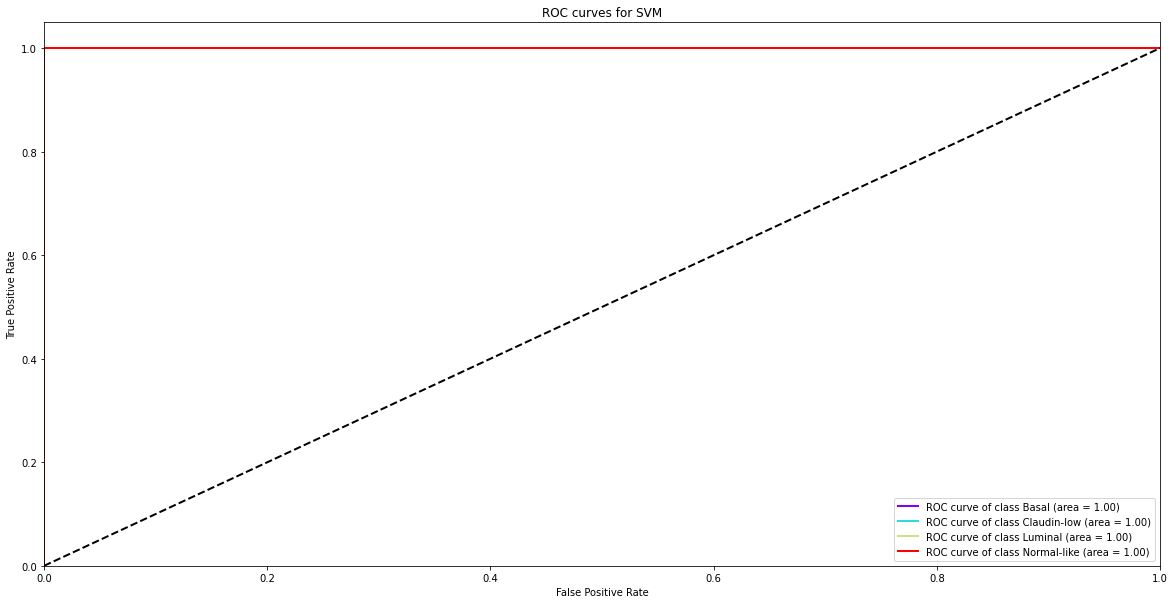

In [ ]:
#Close previous plot
plt.close()

#Plot ROC curves
plt.figure(figsize=(20, 10))

lw = 2

colors = cm.rainbow(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             .format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=10)
plt.ylabel('True Positive Rate', size=10)
plt.title('ROC curves for SVM', size=12)
plt.legend(loc='lower right')
plt.show()